# Assess whether the model is spun up

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib

%matplotlib inline

#### Parameters:

In [2]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

isize = imax - imin
jsize = jmax - jmin

year  = 2002
month = 8

stn_i = np.array([104, 100, 91, 175, 175, 233, 214, 352, 242, 458, 508, 547, 629])
stn_j = np.array([370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

In [3]:
initial   = '/data/brogalla/IC/Mn_ini_20210810.nc' 

In [4]:
colors = ['#f9ddd8', '#f2ac9f', '#ea7a65', '#e5593f', '#a03e2c', \
          '#e0dfea', '#b1b0cc', '#646199', '#46436b', \
          '#3d6977', '#5b9db3', '#84bfd2', '#c1dfe8'] # CB

name   = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4']

#### Load files:

In [5]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]

e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)
hdept      = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [6]:
ref   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
depth = np.array(ref.variables['deptht'])

#### Calculations:

In [7]:
def create_file_list(folder,subfolder,end):
    
    end_yr1 = f'{folder}{subfolder}spin-up0{end}ANHA12_EXH006_2002_monthly.nc'
    end_yr2 = f'{folder}{subfolder}spin-up1{end}ANHA12_EXH006_2002_monthly.nc'
    end_yr3 = f'{folder}{subfolder}spin-up2{end}ANHA12_EXH006_2002_monthly.nc'
    end_yr4 = f'{folder}{subfolder}spin-up3{end}ANHA12_EXH006_2002_monthly.nc'

    file_list = [end_yr1, end_yr2, end_yr3, end_yr4]

    return file_list

In [8]:
def load_file(file):
    
    mn_file    = nc.Dataset(f'{file}')
    mn_monthly = np.array(mn_file.variables['dissolmn'][:,0,:,:,:])
    
    return mn_monthly

In [9]:
def calculate_monthly_difference(file_list):
    mn_monthly = np.zeros((len(file_list),12,50,700,640))
    difference = np.zeros((len(file_list)-1,len(stn_i),12))

    for run, file in enumerate(file_list):
        mn_monthly[run,:,:,:,:] = load_file(file)

        if run > 0: # Depth weighted
            difference[run-1,:,:] = np.array([np.ma.sum(np.abs(mn_monthly[run,:,:,i,j]- \
                                                            mn_monthly[run-1,:,:,i,j])*e3t_masked[:,i,j], axis=1)/hdept[i,j] \
                                              for i, j in zip(stn_i, stn_j)])
    return difference

The year-to-year change is calculated as the sum over all depths of the concentration at the observed stations, $stn$, for each month from one year compared to the previous year. 

$$ diff_{stn} = \frac{1}{hdept} \sum^{50}_{z=0} | Mn_{stn}(z,month,yr) - Mn_{stn}(z,month,yr-1) | e3t(z) $$

In [10]:
clean_ice_files = create_file_list('/data/brogalla/run_storage/Mn-clean-ice-202110/', \
                                   'ANHA12_clean-ice-', '_20211023/')
reference_files = create_file_list('/data/brogalla/run_storage/Mn-reference-202110/', \
                                   'ANHA12_ref-', '_20211012/')
spm_files       = create_file_list('/data/brogalla/run_storage/Mn-spm-202110/', \
                                   'ANHA12_spm-', '_20211026/')
bio_files       = create_file_list('/data/brogalla/run_storage/Mn-bio-202110/', \
                                   'ANHA12_bio-', '_20211022/')

In [11]:
difference_clean_ice = calculate_monthly_difference(clean_ice_files)
difference_reference = calculate_monthly_difference(reference_files)
difference_spm       = calculate_monthly_difference(spm_files)
difference_bio       = calculate_monthly_difference(bio_files)

##### Figures:

In [12]:
def plot_spinup_change(ax, difference, nruns, legend=False):

    months = range(12 +1, 12*nruns +1)
    years  = np.linspace(2, 1+nruns, (nruns-1)*12 + 1)[0:-1]
    
    differences = np.empty((len(name),(nruns-1)*12))
    for stn in range(0,len(name)):
        differences[stn,:] = np.reshape(difference[:,stn,:],((nruns-1)*12))
        ax.plot(years, differences[stn,:], c=colors[stn], label=name[stn], linewidth=1.5)
        ax.plot(years, differences[stn,:], '.', c=colors[stn], markersize=6)

    # Line for spread in values
    ax.plot(years, np.max(differences,axis=0)-np.min(differences,axis=0), '-k', linewidth=2.0, label='spread')

    ax.set_xlim([1.9, 2+nruns-1])
    ax.set_ylim([0, 3.5e-9])
    ax.xaxis.set_ticks(np.linspace(2,2+nruns-1, (nruns-1)*2 + 1))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.get_offset_text().set_fontsize(8)
    ax.set_ylabel(r'Mn change w.r.t. previous year [mol L$^{-1}$]', fontsize=8)
    if legend:
        font = matplotlib.font_manager.FontProperties(size=8)
        ax.legend(loc=(0.45, 0.5), frameon=False, prop=font, ncol=2)
    
    return

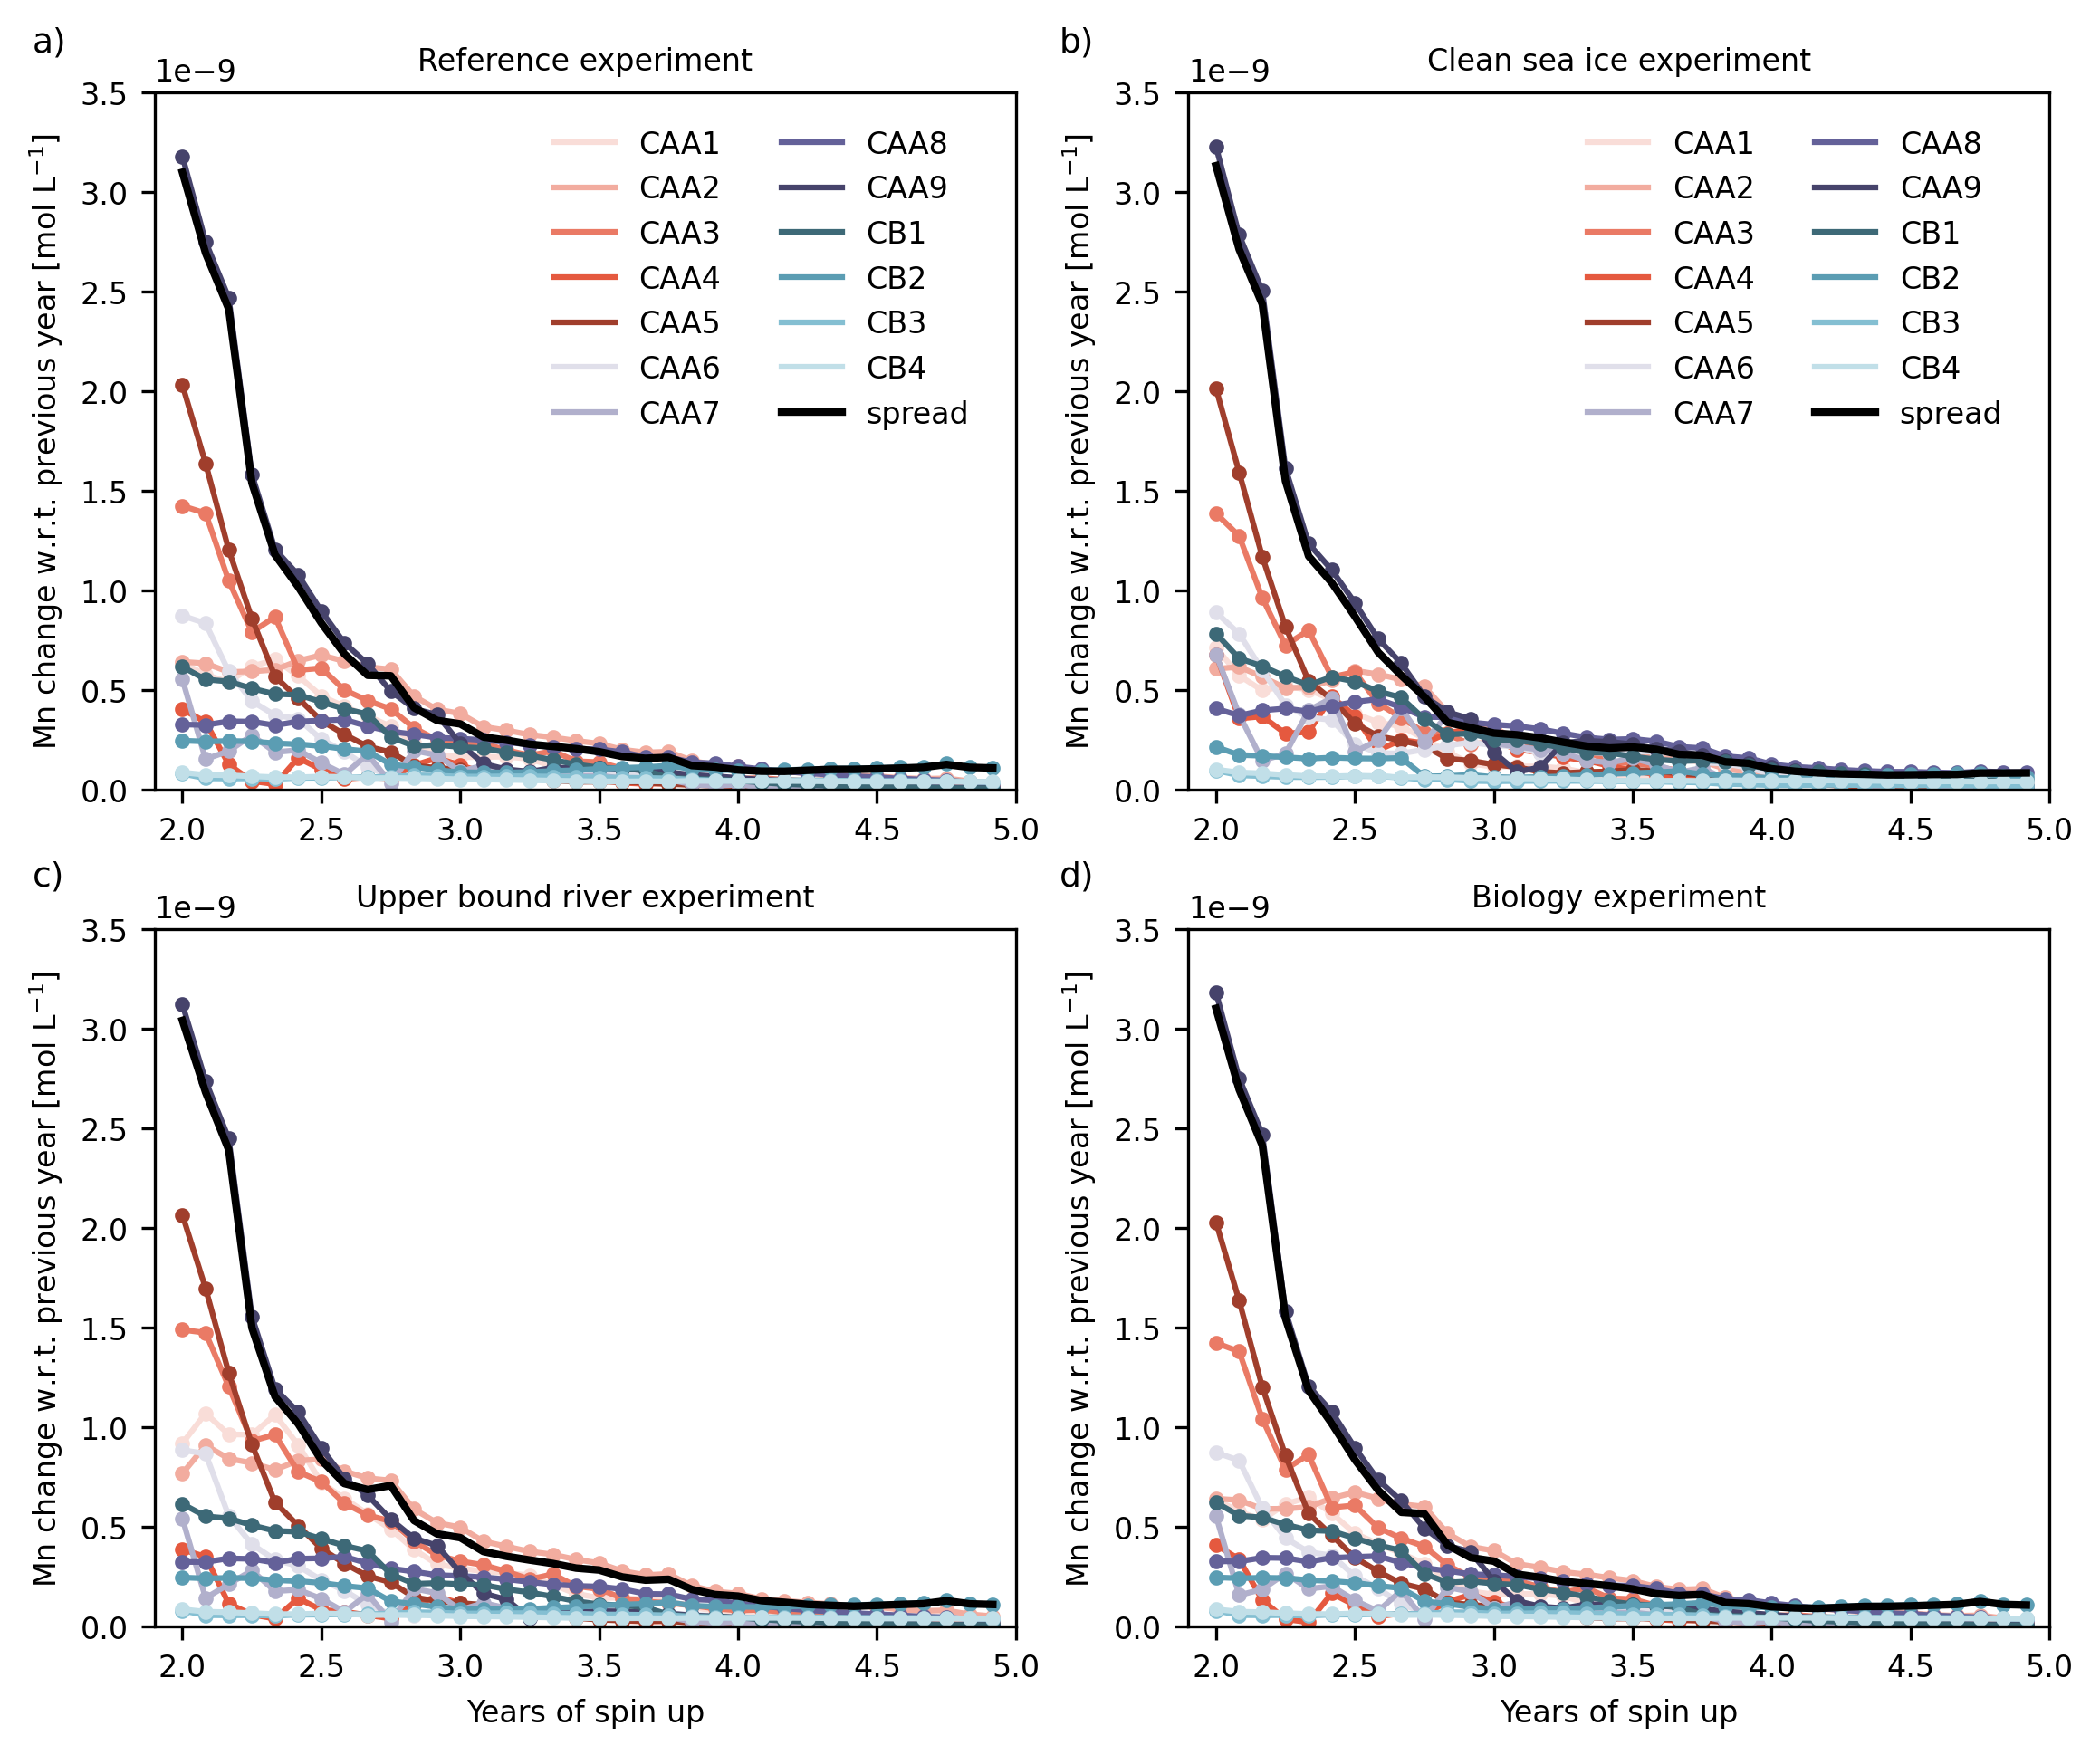

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(4.5*2, 3.74*2), dpi=300)

plot_spinup_change(ax[0,0], difference_reference, 4, legend=True)
plot_spinup_change(ax[0,1], difference_clean_ice, 4, legend=True)
plot_spinup_change(ax[1,0], difference_spm, 4)
plot_spinup_change(ax[1,1], difference_bio, 4)

ax[0,0].set_title('Reference experiment', fontsize=8)
ax[0,1].set_title('Clean sea ice experiment', fontsize=8)
ax[1,0].set_title('Upper bound river experiment', fontsize=8)
ax[1,1].set_title('Biology experiment', fontsize=8)
fig.text(0.075, 0.90, 'a)', fontsize=9);
fig.text(0.495, 0.90, 'b)', fontsize=9);
fig.text(0.075, 0.49, 'c)', fontsize=9);
fig.text(0.495, 0.49, 'd)', fontsize=9);
ax[1,0].set_xlabel('Years of spin up', fontsize=8)
ax[1,1].set_xlabel('Years of spin up', fontsize=8)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S7-spin-up.jpg', bbox_inches='tight', dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S7-spin-up.svg', bbox_inches='tight', dpi=300, \
                    format='svg')